In [67]:
from mobile.config import LOCATIONS, CLIENT_LOCATIONS, HOME_SHIFT
from mobile.utils import *
import time
import geopy

In [44]:
set_cover_lp(set([1,2,3]), [set([1,2]), set([1]), set([2,3])])
set_cover_ip(set([1,2,3]), [set([1,2]), set([1]), set([2,3])])

Solution:
Objective value = 2.0
x1 = 0.0
x2 = 1.0
x3 = 1.0
Solution:
Objective value = 2.0
x1 = 0.0
x2 = 1.0
x3 = 1.0


In [97]:
from ortools.linear_solver import pywraplp
from ortools.linear_solver.pywraplp import Variable, Constraint, Objective
from typing import List, Set

def set_cover_lp(uni: Set[int], R: List[Set[int]]):
    solver = pywraplp.Solver.CreateSolver('GLOP')
    
    #defining variables
    X = []
    for i, S_i in enumerate(R):
        X.append(solver.NumVar(0, 1, 'x' + str(i)))
        
    #setting constraints
    for j in uni:
        cover: Constraint = solver.Constraint(1, solver.infinity())
        
        for i, S_i in enumerate(R):    
            if j in S_i:
                cover.SetCoefficient(X[i], 1)
            else:
                cover.SetCoefficient(X[i], 0)

    #setting objective
    num_sets: Objective = solver.Objective()
        
    for i, S_i in enumerate(R):
        num_sets.SetCoefficient(X[i], 1)
        
    num_sets.SetMinimization()
    
    #solving LP
    print('Solving LP')
    status = solver.Solve()
    
    #printing output
    if status == pywraplp.Solver.OPTIMAL:        
        print('Objective value =', solver.Objective().Value())
    else:
        print('The problem does not have an optimal solution.')
    
    return [X[i].solution_value() for i in range(len(R))]
        
        
def set_cover_ip(uni: Set[int], R: List[Set[int]]):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    #solver.time_limit.seconds = 30
    
    #defining variables
    X = []
    for i, S_i in enumerate(R):
        X.append(solver.IntVar(0, 1, 'x' + str(i)))
        
    #setting constraints
    for j in tqdm.tqdm_notebook(uni):
        cover: Constraint = solver.Constraint(1, solver.infinity())
        
        for i, S_i in enumerate(R):    
            if j in S_i:
                cover.SetCoefficient(X[i], 1)

    #setting objective
    num_sets: Objective = solver.Objective()
        
    for i, S_i in enumerate(R):
        num_sets.SetCoefficient(X[i], 1)
        
    num_sets.SetMinimization()
    
    #solving IP
    print("Solving IP")
    status = solver.Solve()
    
    #printing output
    if status == pywraplp.Solver.OPTIMAL:
        print('Objective value =', solver.Objective().Value())
    else:
        print('The problem does not have an optimal solution.')
        
    return [X[i].solution_value() for i in range(len(R))]

In [99]:
pywraplp.Solver.FEASIBLE

1

In [ ]:
sol = set_cover_ip(ans[2], radius_list)
print(sum(sol))

<ipython-input-97-906fce1b60da>:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm.tqdm_notebook(uni):


In [83]:
from ortools.sat.python import cp_model
model = cp_model.CpModel()
#solver = pywraplp.Solver.CreateSolver('GUROBI_IP')
print(model)

In [50]:
def set_cover_softmax(neighbors, radius: float, top: int = 1, times: int = 1):

    radius_dict = {}

    for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):

        radius_dict[l] = set()

        for n in neighbor:

            if n[0] <= radius:                
                ngbr = n[1]
                radius_dict[l] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
            else:
                break
    
    total_length = len(CLIENT_LOCATIONS)
    radius_dict_id = ray.put(radius_dict)
    
    
    #@ray.remote
    #def process(radius_dict):
    print('starting process')
    covered = set()
    chosen = set()

    while len(covered) != total_length:

        max_coverage = []

        for loc in radius_dict.keys():

            if loc not in chosen:

                individuals_covered = radius_dict[loc] - covered
                max_coverage.append((len(individuals_covered), loc, individuals_covered))

        max_coverage = sorted(max_coverage, reverse = True)

        if max_coverage[0][0] == 0:
            break

        choice = max_coverage[scipy.stats.boltzmann.rvs(lambda_=0.8, N=top)]

        covered = covered.union(choice[2])
        chosen.add(choice[1])
        print(len(covered))
            
    return (len(chosen), chosen, covered)
    
    #print("here")
    #results = [ray.get(process.remote(radius_dict_id)) for _ in range(times)]
    #results = sorted(results)
       
    
    #return results[0][1]

In [22]:
#CLIENT_LOCATIONS.keys()

In [16]:
import tqdm

def generate_sorted_list():
    
    start = time.time()
    
    neighbors = {}
    
    LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]
    
    for l in tqdm.tqdm_notebook(LOCATIONS_act):
        sorted_distance_neighbors = []
        
        for j in range(len(LOCATIONS)):
            dist = calculate_distance(l, j)
            sorted_distance_neighbors.append((dist, j))
            
        sorted_distance_neighbors = sorted(sorted_distance_neighbors, reverse = False)
        neighbors[l] = sorted_distance_neighbors
    
    end = time.time()
    print(end-start)
    
    return neighbors

In [ ]:
neighbors = generate_sorted_list()

In [64]:
radius = 0.5
correspondence = []
radius_list = []

for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):

    correspondence.append(l)
    covered_ell = set()

    for n in neighbor:

        if n[0] <= radius:                
            ngbr = n[1]
            covered_ell = covered_ell.union(LOCATIONS[ngbr]['pid'])
        else:
            radius_list.append(covered_ell)
            break

<ipython-input-64-49b0529dda6f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):


In [78]:
sol = set_cover_ip(ans[2], radius_list)

AttributeError: 'Solver' object has no attribute 'parameters'

In [68]:
sol2 = set_cover_lp(ans[2], radius_list)

Solving LP
Objective value = 26.329291575907977


In [58]:
set(CLIENT_LOCATIONS.keys())-set(ans[2])
print(len(CLIENT_LOCATIONS))

{5617257, 5603252}
33156


In [63]:
import numpy as np
import scipy
import scipy.stats
import scipy.special
import ray

ans = set_cover_softmax(neighbors, 0.5, 10, 40)

<ipython-input-50-ce6a3c169046>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):



starting process
26372
30918
31664
32114
32417
32605
32742
32818
32872
32917
32957
32982
33006
33026
33043
33058
33072
33083
33093
33101
33109
33115
33120
33125
33129
33133
33136
33139
33142
33145
33147
33149
33150
33151
33152
33153
33154
33155
33156


In [13]:
sum(sol)

0.0

In [ ]:
import numpy as np
import scipy
import scipy.stats
import scipy.special
import ray

ans = set_cover_softmax(neighbors, 1.5, 10, 40, True)
print(len(ans))
ans = set_cover_softmax(neighbors, 1.5, 10, 40, False)
print(len(ans))

/home/dpm7pb/.local/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


In [ ]:
if parallel:
        a = time.time()
        ray.init(ignore_reinit_error=True)
        LOCATIONS_id = ray.put(LOCATIONS)

        @ray.remote
        def process1(neighbor, LOCATIONS):
            arr = set()

            for n in neighbor:

                if n[0] <= radius:                
                    ngbr = n[1]
                    arr = arr.union(LOCATIONS[ngbr]['pid'])
                else:
                    break

            return arr

        radius_dict = {l:ray.get(process1.remote(neighbor, LOCATIONS_id)) for (l, neighbor) in neighbors.items()}
        print(time.time()-a)


In [ ]:
from mobile.config import PROJECT_ROOT
with open(PROJECT_ROOT/ 'output'/ 'runs'/ 'charlottesville_city' / f'neighbors.json', 'r') as f:
    data = json.load(f)
    neighbors = data['neighbors']

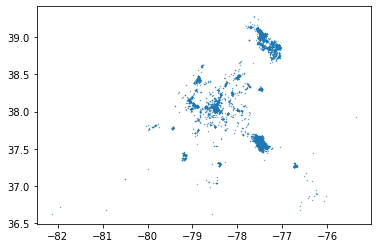

In [37]:
plt.scatter(x=locations['longitude'],y=locations['latitude'], s=0.1)

In [30]:
residents.head()

,rlid,longitude,latitude,altitude,admin1,admin2,admin3,admin4,area_sqm,associate_link_func_class,...,pub_03,pub_04,pub_05,pub_06,pub_07,pub_08,pub_09,pub_10,pub_11,pub_12
0,17044,-78.475050,38.066151,-1,51,540,800,1,169,5,...,77881,77881,77883,77883,77688,77688,77880,77880,77880,77880
1,17046,-78.473818,38.069160,-1,51,540,800,1,171,5,...,77881,77881,77883,77883,77688,77688,77880,77880,77880,77880
2,17061,-78.497536,38.059734,-1,51,540,800,4,263,5,...,77885,77885,77883,77883,77672,77672,77880,77880,77880,77880
3,17063,-78.498064,38.060366,-1,51,540,800,4,156,5,...,77881,77881,77883,77883,77672,77672,77880,77880,77880,77880
4,17064,-78.486814,38.060308,-1,51,540,800,4,248,5,...,77881,77881,77883,77883,77688,77688,77880,77880,77880,77880


In [77]:
residents.columns

Index(['rlid', 'longitude', 'latitude', 'altitude', 'admin1', 'admin2',
       'admin3', 'admin4', 'area_sqm', 'associate_link_func_class', 'pub_pk',
       'pub_kg', 'pub_01', 'pub_02', 'pub_03', 'pub_04', 'pub_05', 'pub_06',
       'pub_07', 'pub_08', 'pub_09', 'pub_10', 'pub_11', 'pub_12'],
      dtype='object')

In [31]:
residents.shape

(10038, 24)

In [28]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%load_ext autoreload
%autoreload 2

from utils import *
from heuristics import _k_supplier
import geopy
import math
import time
from joblib import Parallel, delayed


def fpt2_parallel(k: int, s: int):
    """
    Assumes the number of locations visited by clients is bounded by a constant
    Run k-supplier on all combination sets of locations that will be covered by facilities. Select the guess and its open facilities with the smallest objective value.
    
    PARAMETERS
    ----------
    k : int
        number of facilities to be opened
    
    RETURNS
    ----------
    facilities : List[int]
        contains facility indices that are open
    assignments : List[Tuple[int, int]]
        visited location and facility assignment indexed by each client
    """
    potential_facility_locations = list(range(s))
    
    #Remove homes from the client_location lists
    #TODO: Perhaps create mapping for the indices of people before exclusion and after?
    client_locations_excluded = []
    for person in CLIENT_LOCATIONS.values():
        new_list = [p for p in person['lid'][1:] if p in potential_facility_locations]
        if len(new_list)>0:
            client_locations_excluded.append(new_list)
    
    locations = [i for i in range(len(LOCATIONS)) if LOCATIONS[i]['lid'] < HOME_SHIFT]
    
    G, loc_map, c_loc_map = precompute_distances(client_locations_excluded, locations)
    
    def process(guess):
        facilities = _k_supplier(list(guess), locations, k)
        obj_value = assign_client_facilities2(G, loc_map, c_loc_map, client_locations_excluded, facilities)
        
        return obj_value, facilities

    results = Parallel(n_jobs=16)(delayed(process)(guess) for guess in powerset(list(potential_facility_locations)))
    
    min_obj_guess: Tuple[int, List[int]] = min(results)
    return min_obj_guess, assign_facilities(min_obj_guess[1])

In [19]:
from heuristics import *

In [5]:
(val, asgn) = fpt3_parallel2(5, 15, 0)

COVERAGE OF CLIENTS BY 15 LOCATIONS:  0.8028109542767523


2021-08-17 19:20:15,752	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


KeyboardInterrupt: 

In [6]:
calculate_objective(asgn)

2.3956977875908194

In [20]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range((len(s)+1)//2,-1,-1))

In [29]:
print([i for i in range(1,5)])

[1, 2, 3, 4]


In [7]:
from heuristics import *

fac1, asgn1 = center_of_homes(5)
print(calculate_objective(asgn1))


1.993687977423548


In [9]:
home_obj = [calculate_percentile_objective(asgn1, i/100) for i in range(50,101,1)]

In [8]:
fac2, asgn2 = center_of_centers(5)
print(calculate_objective(asgn2))

6.395545048189607


In [10]:
center_obj = [calculate_percentile_objective(asgn2, i/100) for i in range(50,101,1)]

In [12]:
import matplotlib.pyplot as plt
x = [i for i in range(50,101,1)]

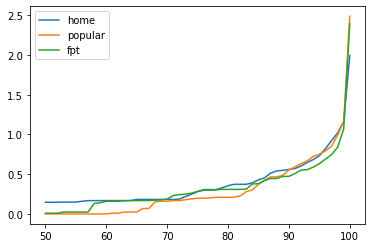

In [46]:
plt.plot(x, home_obj, label='home')
#plt.plot(x, center_obj, label='center')
plt.plot(x, pop_obj, label='popular')
plt.plot(x, fpt_obj, label='fpt')
plt.legend()

In [41]:
import json
with open("fpt_exp_sensitivity_0.json", 'r') as file:
    j = json.load(file)
    
    asgn4 = j['(5, 15)']['assignments']
    
#fpt_obj = [calculate_percentile_objective(asgn4, i/100) for i in range(50,101,1)]

with open("fpt_exp_sensitivity_1.json", 'r') as file:
    j = json.load(file)
    
    asgn5 = j['(5, 20)']['assignments']
    
fpt_obj = [calculate_percentile_objective(asgn5, i/100) for i in range(50,101,1)]

In [44]:
fac3, asgn3 = most_populous_agg(5, 1)
pop_obj = [calculate_percentile_objective(asgn3, i/100) for i in range(50,101,1)]

In [21]:
def most_populous(k: int):
    return list(range(k)), assign_facilities(list(range(k)))

In [ ]:
def center_of_centers2(k: int):
    """
    PARAMETERS
    ----------
    k : int
        number of facilities to be opened
    
    RETURNS
    ----------
    facilities : List[int]
        contains facility indices that are open
    assignments : List[Tuple[int, int]]
        visited location and facility assignment indexed by each client
    """
    clients = []
    
    for client_row in CLIENT_LOCATIONS.values():
        
        client = client_row["lid"]
        
        dispersion = 1e10
        effective_center = -1
        
        for center in client:
            
            max_dist = 0
            
            for loc in client:
                max_dist = max(calculate_distance(center, loc), max_dist)
                
            if max_dist < dispersion:
                dispersion = max_dist
                effective_center = center
                
        clients.append(effective_center)
        
    locations = [i for i in range(len(LOCATIONS)) if LOCATIONS[i]['lid'] < HOME_SHIFT]
    facilities = _k_supplier(clients, locations, k)
    
    return facilities, assign_facilities(facilities)